# Experiments with the joining validator

In this notebook we experiment with different configurations of the joining validator. In the previous experiments we have been using the default configuration of the joining validator, namely a RandomForestClassifier (adaptive) validation parameters. In this notebook we will experiment with different configurations of the joining validator strategy, namely:

- Different classifiers: we will experiment with different classifiers, such as KNN, SVM, and MLP.
- One class classification and Outlier Detection models: Using different kinds of validator models from the basic classification scheme may have an effect?
- Different thresholds: we will experiment with different thresholds to see if privacy/utility trade-offs can be controlled.

Alltogether we hope to begin to answer the question; Wheather or not a better or worse performance of the joining validator is desired, what configurations should be used?

For the low level results, we will continue using the Hepatitis dataset split into categorical and numerical partitions, but for the high level results we will also explore other datasets. We will focus on the synthpop-ADSGAN DGM, because it has more room for improvement than the DataSynthesizer-DPGAN DGM.

## High level results

First, we will show the big experiment also presented in the paper. The figure shows all the datasets used in the study, with categorical and numerical partitions distributed to synthpop and ADSGAN respectively, and using different joining validators. The noteworthy results are highlighted in the figure.

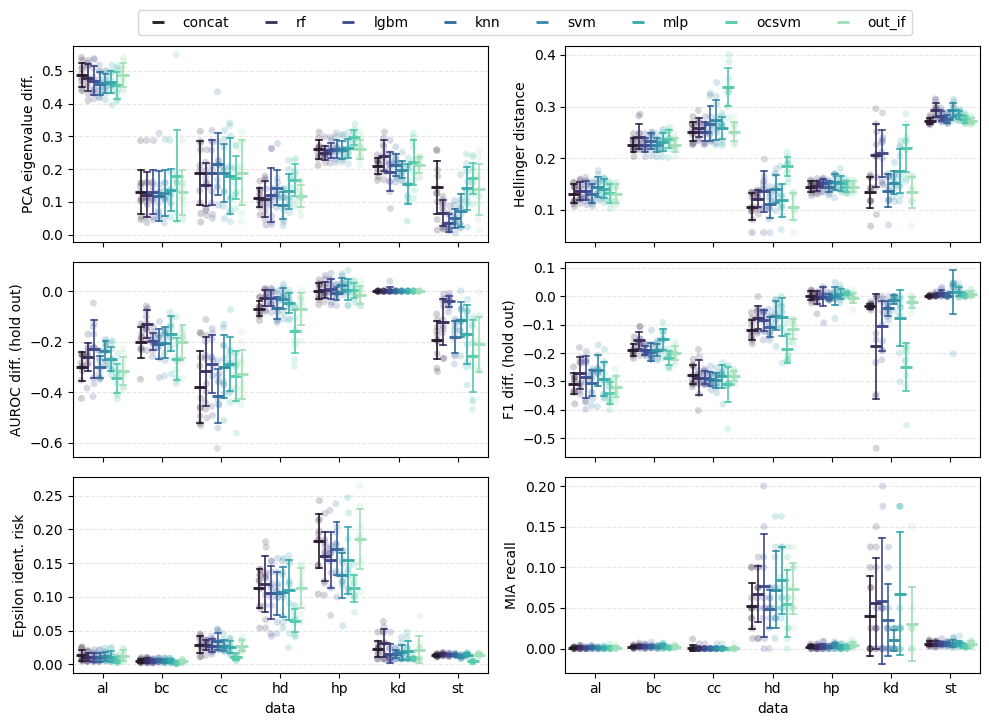

In [3]:
import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 10, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_validator_pointplot(datapath: str, metrics: Dict[str,str]) -> None:
    """ Function to plot a pointplot with mean results of the different validators for each metric."""

    df = pd.read_csv(datapath)

    validators = df['validator'].unique()
    df = df[['data', 'validator'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(len(metrics)//2, 2, figsize=(10, 1+len(metrics)), sharex=True)

    colors = sns.color_palette("mako", n_colors=len(validators))    

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.stripplot(
            data=df, x="data", y=metric, hue="validator",
            alpha=0.2, legend=False, palette=colors, dodge=True, ax=axes[i]
        )
        sns.pointplot(
            data=df, x="data", y=metric, hue="validator",
            linestyle="none", dodge=.8 - .8 / len(validators), err_kws={'linewidth':1.2}, capsize=0.1, errorbar='sd',
            palette=colors, markersize = 8, markers="_", ax=axes[i]
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        axes[i].get_legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=10, bbox_to_anchor=(0.53, 1.04), bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.savefig("experiments/figures/figure7_validator_pointplot.pdf", bbox_inches='tight')
    plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "avg_h_dist": "Hellinger distance",
    "auroc": "AUROC diff. (hold out)",
    "avg_F1_diff_hout": "F1 diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

make_validator_pointplot("experiments/results/04_validator_models.csv", metrics)

Based on this plot there seems to be no clear better choice than the random forest model with its default configuration, some models do better or worse on certain datasets, the differentially private random forest model, the one class svm, and outlier models stand out a bit doing generally better on privacy but worse on utility. More than any one classifier being a profoundly better choice, the results hint at the strictness/lenience of the joining validator impacting the trade-off between privacy and utility

This needs to be further investigated.

## Fixed threshold experiments

In the next series of experiments we use a the same validator models but affix the threshold at different positions. We will use the Hepatitis dataset for this experiment.

### Calibration and optimisation

First we need to find acceptable joining validator models and optimise it for best performance on this dataset

The plots seen here sonstitute Figure 8 in the paper.

In [9]:
import json
import pandas as pd

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

with open("experiments/results/saved_partitionings/hp_corr_parts.json", "r") as f:
    predefined_splits = json.load(f)

print(predefined_splits)

{'split0': ['RNA EOT', 'ALT 24', 'Diarrhea', 'BMI', 'Epigastric pain', 'Age', 'Headache', 'Plat', 'Fatigue & generalized bone ache', 'AST 1', 'Nausea/Vomting', 'Gender', 'ALT 36', 'Fever', 'RNA Base', 'b_class'], 'split1': ['RNA EF', 'ALT 48', 'HGB', 'Jaundice', 'RNA 12', 'ALT 1', 'ALT 12', 'ALT 4', 'RNA 4', 'Baseline histological Grading', 'RBC', 'ALT after 24 w', 'WBC']}


DataManager: The exterior correlations are 1.62 times that of the interiors.
Validator: No search parameters specified. Using default configuration.


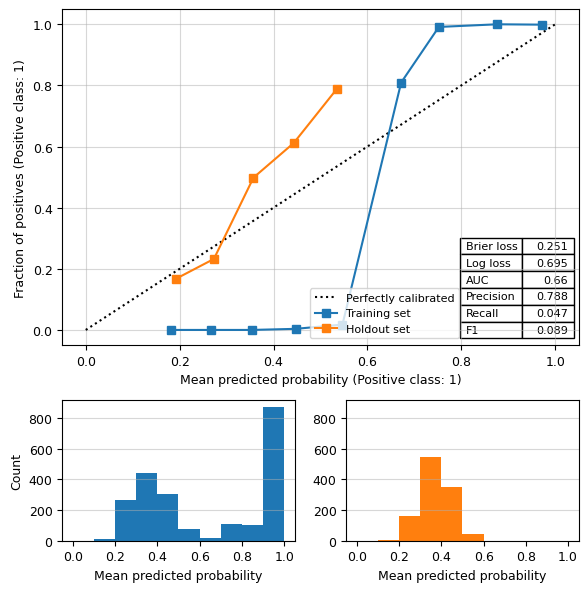

In [ ]:
### Base Sci-kit-learn model with no hyper-parameter tuning or calibration
import pickle
from typing import Literal

from sklearn.ensemble import RandomForestClassifier
from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method: Literal['sigmoid', 'isotonic'] | None) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train,['temp_1', 'temp_2'], predefined_splits, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=True)
    return dgms

validator_model = RandomForestClassifier()

dgms = hyper_params_search(validator_model, None, None)

with open('experiments/validator_models/hp_rf_scikit.obj', 'wb') as file:
    pickle.dump(dgms._strategy.join_validator, file)

DataManager: The exterior correlations are 1.62 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.671493 using {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 9}
Validator: Calibration improved the model from 0.8968 to 0.8971


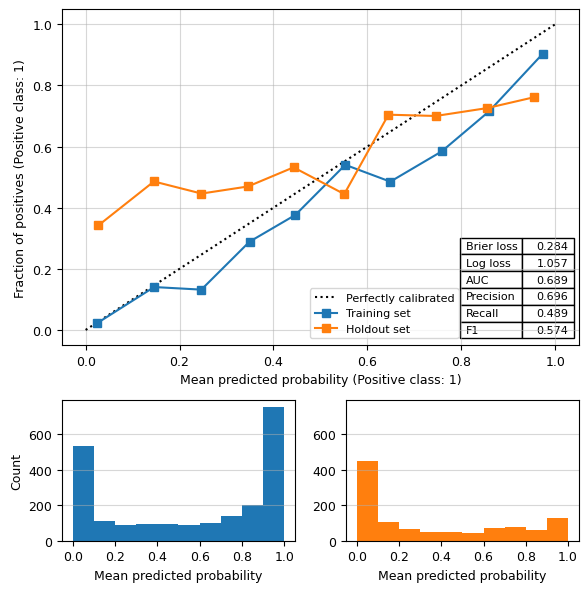

In [ ]:
### Optimised model (best balance found in this case study)
import pickle
from typing import Literal

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, Normalizer, FunctionTransformer
from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method: Literal['sigmoid', 'isotonic'] | None) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train,['temp_1', 'temp_2'], predefined_splits, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=True)
    return dgms

validator_model = make_pipeline(QuantileTransformer(n_quantiles=250), RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample'))
parameter_grid = {
    'randomforestclassifier__n_estimators': [5, 9,10], 'randomforestclassifier__max_depth': [5, 9,10]
}
calibration_method = 'sigmoid'
#'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20
dgms = hyper_params_search(validator_model, parameter_grid, calibration_method)

# with open('experiments/validator_models/hp_rf_opt.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

DataManager: The exterior correlations are 1.62 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.687783 using {'max_depth': 10, 'n_estimators': 10}
Validator: Calibration did not improve the model. Using the original model.


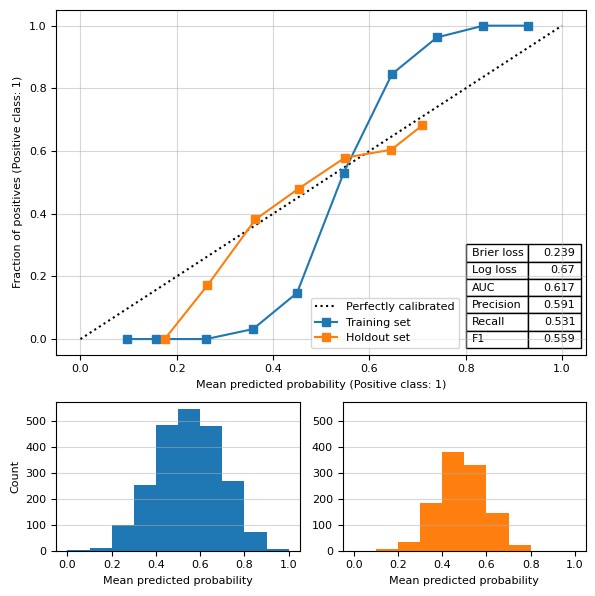

In [ ]:
### Suboptimal model (inadequate resources for the search)
import pickle
from typing import Literal

from sklearn.ensemble import RandomForestClassifier
from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method: Literal['sigmoid', 'isotonic'] | None) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train,['temp_1', 'temp_2'], predefined_splits, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=True)
    return dgms

validator_model = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
parameter_grid = {
    'n_estimators': [3,5,10], 'max_depth': [3, 5, 10, 12]
}
calibration_method = 'sigmoid'

dgms = hyper_params_search(validator_model, parameter_grid, calibration_method)

# with open('experiments/validator_models/hp_rf_undcon.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

DataManager: The exterior correlations are 1.62 times that of the interiors.
Validator: Grid search for hyperparameters
Validator: Best score 0.744570 using {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 50}
Validator: Calibration improved the model from 0.9995 to 0.9995


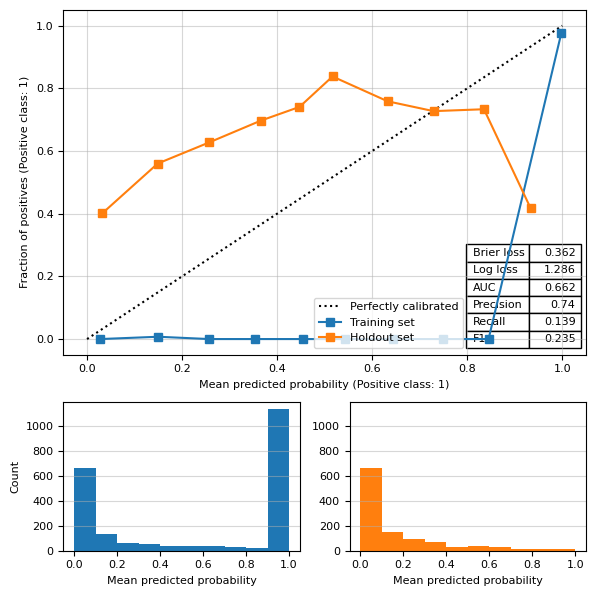

In [ ]:
### Overconfident model (not used in the paper)
import pickle
from typing import Literal

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

from disjoint_generation import DisjointGenerativeModels
from disjoint_generation.utils.joining_validator import JoiningValidator
from disjoint_generation.utils.joining_strategies import UsingJoiningValidator

def hyper_params_search(validator_model: object, parameter_grid: dict, calibration_method: Literal['sigmoid', 'isotonic'] | None) -> None:

    JV = JoiningValidator(validator_model, model_parameter_grid = parameter_grid, calibration_method=calibration_method, verbose=True)
    JS = UsingJoiningValidator(JV)
    dgms = DisjointGenerativeModels(df_train,['temp_1', 'temp_2'], predefined_splits, joining_strategy=JS)
    dgms.num_samples = 20 # required or it will throw an error
    dgms._setup()
    
    dgms._make_calibration_plot(df_test, save=False, stats=True)
    return dgms

validator_model = make_pipeline(RobustScaler(), RandomForestClassifier())
parameter_grid = {
    'randomforestclassifier__n_estimators': [5, 10, 50], 
    'randomforestclassifier__max_depth': [5, 10, 20],
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
}
calibration_method = 'sigmoid'

dgms = hyper_params_search(validator_model, parameter_grid, calibration_method)

# with open('experiments/validator_models/hp_rf_ovrcon.obj', 'wb') as file:
#     pickle.dump(dgms._strategy.join_validator, file)

### Results

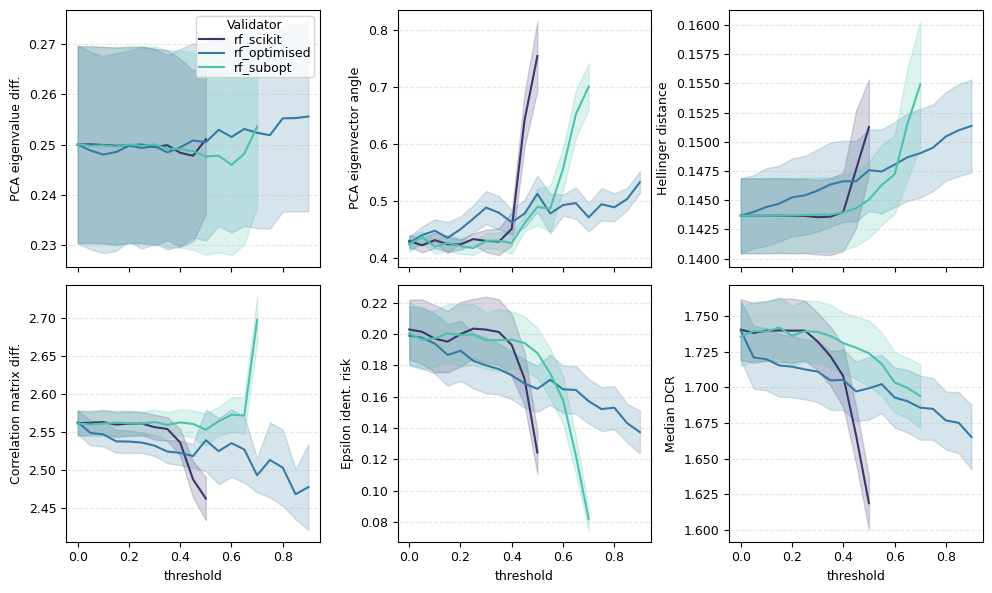

In [2]:
import numpy as np
import pandas as pd

from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def make_threshold_continuum_plot(datapath: str, series: str, dataset: str, valid_models: List[str], metrics: Dict[str,str]) -> None:
    """ This plot shows how the performance of different metrics vary 
    with using different validators at different threshold. """

    df = pd.read_csv(datapath)
    df = df[df['experiment'] == series]

    df = df[df['validator'].isin(valid_models)]
    df = df[df['data'] == dataset]
    df = df[['validator', 'threshold'] + list(metrics.keys())]

    # Create the pointplot
    fig, axes = plt.subplots(int(np.ceil(len(metrics)/3)), 3, figsize=(10, 3*int((np.ceil(len(metrics)/3)))), sharex=True)

    colors = sns.color_palette("mako", n_colors=len(valid_models))

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        sns.lineplot(
            data=df, x="threshold", y=metric, hue="validator",
            palette=colors, ax=axes[i], errorbar='se'
        )
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
        axes[i].set_ylabel(metrics[metric])

        if i == 0:
            axes[i].legend(title="Validator", ncols=1, borderpad=0.2, labelspacing=0.1, columnspacing=0.5)
        else:
            axes[i].get_legend().remove()

    if len(axes) > len(metrics):
        for j in range(len(metrics), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig("experiments/figures/figure9_threshold_continuum_plot.pdf", bbox_inches='tight')
    # plt.show()
    pass

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "pca_eigvec_ang" : "PCA eigenvector angle",
    "avg_h_dist": "Hellinger distance",
    "corr_mat_diff": "Correlation matrix diff.",
    "eps_identif_risk": "Epsilon ident. risk",
    "median_DCR": "Median DCR",
}

SERIES = "sp_dp"

make_threshold_continuum_plot("experiments/results/04_threshold_results.csv", SERIES, "hp", ['rf_scikit', 'rf_optimised', 'rf_subopt'], metrics)

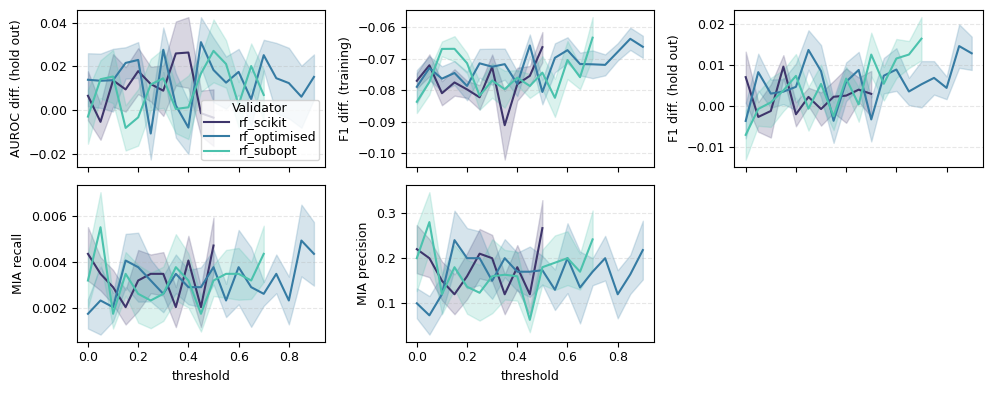

In [3]:

metrics = {
    "auroc": "AUROC diff. (hold out)",
    "avg_F1_diff": "F1 diff. (training)",
    "avg_F1_diff_hout": "F1 diff. (hold out)",
    "mia_recall": "MIA recall",
    "mia_precision": "MIA precision",
}

SERIES = "sp_dp"

make_threshold_continuum_plot("experiments/results/validator_case_study/04_threshold_results.csv", SERIES, "hp", ['rf_scikit', 'rf_optimised', 'rf_subopt'], metrics)

In [4]:
# retrieve metrics for experiment series at thresholds
def extract_results(datapath: str, series: str, dataset: str, valid_model: str, threshold: float) -> None:

    df = pd.read_csv(datapath)
    df = df[df['experiment'] == series]

    df = df[df['validator'] == valid_model]
    df = df[df['data'] == dataset]
    
    if threshold is not None:
        df = df[df['threshold'] == threshold]

        df = df.drop(columns=['rep_idx', 'experiment', 'data', 'validator', 'threshold'])
    else:
        df = df.drop(columns=['rep_idx', 'experiment', 'data', 'validator'])
    mean_values = df.mean()
    sem_error = df.sem()

    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])
    
    print(f"Results for validator {valid_model} at threshold {threshold}:")
    print(results)
    pass

extract_results("experiments/results/04_validator_models.csv", SERIES, "hp", "concat", None)
extract_results("experiments/results/04_threshold_results.csv", SERIES, "hp", "rf_scikit", 0.5)
extract_results("experiments/results/04_threshold_results.csv", SERIES, "hp", "rf_optimised", 0.9)
extract_results("experiments/results/04_threshold_results.csv", SERIES, "hp", "rf_subopt", 0.65)

Results for validator concat at threshold None:
                      mean       sem
pca_eigval_diff   0.260493  0.009339
pca_eigvec_ang    0.443408  0.013475
avg_h_dist        0.145136  0.003125
corr_mat_diff     2.564817  0.024497
auroc             0.000320  0.010040
avg_F1_diff      -0.071660  0.005516
avg_F1_diff_hout  0.002015  0.004873
eps_identif_risk  0.182624  0.012760
priv_loss_eps     0.092941  0.007022
mia_recall        0.002319  0.000580
mia_precision     0.140000  0.033993
Results for validator rf_scikit at threshold 0.5:
                      mean       sem
pca_eigval_diff   0.251038  0.014868
pca_eigvec_ang    0.755064  0.060378
avg_h_dist        0.151265  0.004056
corr_mat_diff     2.462051  0.028667
auroc            -0.003408  0.012934
avg_F1_diff      -0.066372  0.004802
avg_F1_diff_hout  0.003061  0.005588
eps_identif_risk  0.124253  0.013719
priv_loss_eps     0.058100  0.008604
median_DCR        1.618764  0.018810
mia_recall        0.004710  0.001217
mia_precision 